## Ablation Analysis

The .tif files uploaded were previously treated in ImageJ. 

1. Median 3D: X radius = Y radius = Z radius = 2.0
3. Select ROIs: vTel and POA
4. Z Projection SUM: 80 slices

ROIs: 
- ventral telencephalon (vTel)
- preoptic area (POA)

In [1]:
import os
import glob
import cv2 

from scipy import ndimage
from scipy import stats
import scikit_posthocs as sp
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import cm
import seaborn as sns
import ptitprince as pt
from scipy.spatial import distance
import pandas as pd

from PIL import Image
from skimage.external.tifffile import imread
from skimage.external.tifffile import imshow
from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.feature import peak_local_max

import numpy as np
import plotly.graph_objects as go
import math

#%matplotlib inline
import mpld3
mpld3.enable_notebook()

###  Loadind the .tif files

Given the stack of images was summed, the intensity values do not range from 0-256. Therefore, before segementation we need to normalize the image to 8-uint format.

In [2]:
def load_tif(files):
    group = []
    
    for file in files:
        im_open = Image.open(file)
        im_read = imread(file)    
        im = cv2.normalize(im_read,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U)
        group.append(im)
        
    
    return group

In [3]:
paths = []

for roi in ['center','diencephalon', 'periphery', 'vtel']:
    for treatment in ['dDMSO','vDMSO','dMTZ','vMTZ']:
        
        path = glob.glob(f'/media/renata/renata_data_2/Figures_Ablation/roi_{roi}/{treatment}/*.tif')
        paths.append(path)


c_dd_paths = paths[0]
c_dv_paths = paths[1]
c_md_paths = paths[2]
c_mv_paths = paths[3]
d_dd_paths = paths[4]
d_dv_paths = paths[5]
d_md_paths = paths[6]
d_mv_paths = paths[7]
p_dd_paths = paths[8]
p_dv_paths = paths[9]
p_md_paths = paths[10]
p_mv_paths = paths[11]
t_dd_paths = paths[12]
t_dv_paths = paths[13]
t_md_paths = paths[14]
t_mv_paths = paths[15]

The groups names:

1. roi (c-center, d-diencephalon, p-periphery, t-ventral telencaphalon)
2. treatment (d-dmso, m-mtz) 
3. side view (d-dorsal, v-ventral) 

In [4]:
# Loading the tif files from all the groups

r_c_dd = load_tif(c_dd_paths)
r_c_dv = load_tif(c_dv_paths)
r_c_md = load_tif(c_md_paths)
r_c_mv = load_tif(c_mv_paths)
r_d_dd = load_tif(d_dd_paths)
r_d_dv = load_tif(d_dv_paths)
r_d_md = load_tif(d_md_paths)
r_d_mv = load_tif(d_mv_paths)
r_p_dd = load_tif(p_dd_paths)
r_p_dv = load_tif(p_dv_paths)
r_p_md = load_tif(p_md_paths)
r_p_mv = load_tif(p_mv_paths) 
r_t_dd = load_tif(t_dd_paths)
r_t_dv = load_tif(t_dv_paths)
r_t_md = load_tif(t_md_paths)
r_t_mv = load_tif(t_mv_paths)

In [5]:
# Shapes for each ROI

print(np.shape(r_c_dd))
print(np.shape(r_d_dd))
print(np.shape(r_p_dd))
print(np.shape(r_t_dd))


(9, 132, 126)
(9, 212, 162)
(9, 132, 126)
(9, 338, 356)


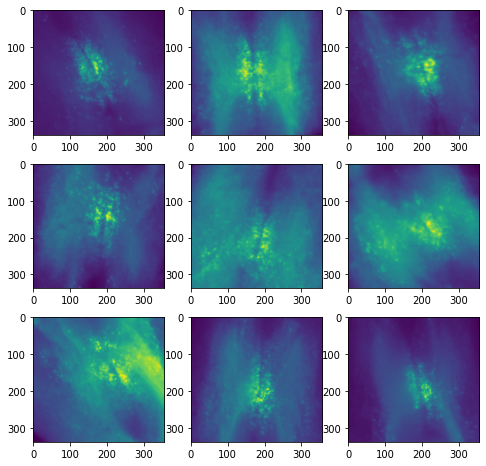

In [6]:
# Example for the positive control for the vTel roi, ventral side 

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3


for i in range(1, columns*rows+1):
    img = r_t_dv[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

### Segmentation: Local Gradient

In [7]:
def segmentation(group):
    group_seg = []
    
    for image in group: 

        #local gradient
        gradient = rank.gradient(image, disk(2))
        group_seg.append(gradient)
        
    return group_seg

In [8]:
lg_c_dd = segmentation(r_c_dd)
lg_c_dv = segmentation(r_c_dv)
lg_c_md = segmentation(r_c_md)
lg_c_mv = segmentation(r_c_mv)
lg_d_dd = segmentation(r_d_dd)
lg_d_dv = segmentation(r_d_dv)
lg_d_md = segmentation(r_d_md)
lg_d_mv = segmentation(r_d_mv)
lg_p_dd = segmentation(r_p_dd)
lg_p_dv = segmentation(r_p_dv)
lg_p_md = segmentation(r_p_md)
lg_p_mv = segmentation(r_p_mv) 
lg_t_dd = segmentation(r_t_dd)
lg_t_dv = segmentation(r_t_dv)
lg_t_md = segmentation(r_t_md)
lg_t_mv = segmentation(r_t_mv)

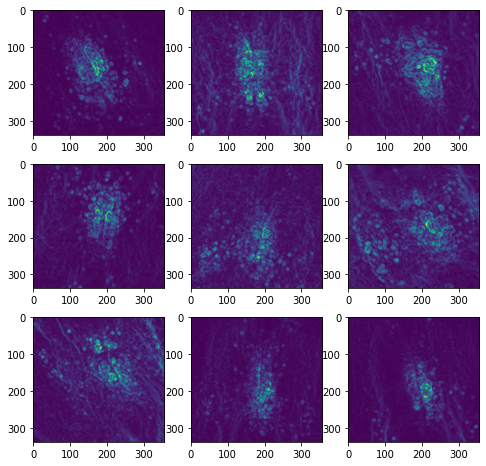

In [9]:
# Example for the positive control for the vTel roi, dorsal side 

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3


for i in range(1, columns*rows+1):
    img = lg_t_dv[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

###  Identidication of the peaks

In [10]:
def id_peaks(group):
    
    fig = plt.figure(figsize=(10, 10))
    columns = 3
    rows = 3


    for i in range(1, columns*rows+1):
        
        img = group[i-1]
        peaks = peak_local_max(img, threshold_abs=6, indices=True) # Get the coordinates
        
        x = peaks[:,0]
        y = peaks[:,1]
        
        fig.add_subplot(rows, columns, i)
        
        plt.scatter(x, y, s=4)

    plt.show()


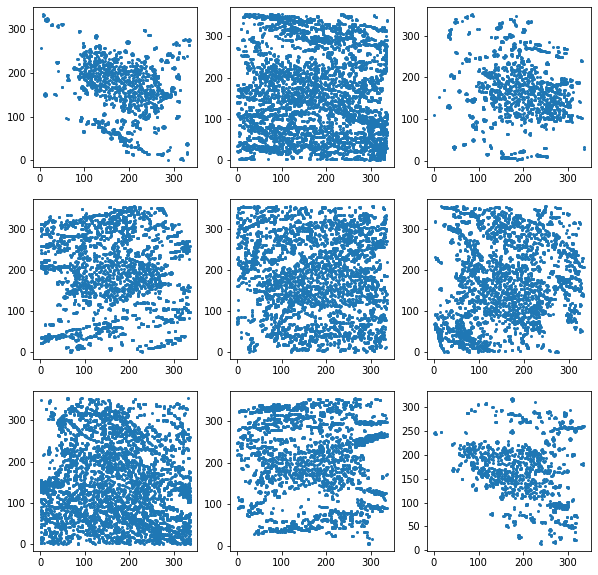

In [11]:
id_peaks(lg_t_dd)

In [12]:
# Here, I'm deviding the whole roi with their mean value and finding the peaks of intensity of the resulting image
from matplotlib import pyplot, transforms

def id_peaks2(group):
    
    fig = plt.figure(figsize=(12, 12))
    columns = 3
    rows = 3


    for i in range(1, columns*rows+1):
        
        img = group[i-1]
        norm_img = img/np.nanmedian(img)
        peaks = peak_local_max(norm_img, threshold_abs=4, indices=True) # Get the coordinates
        #print(np.shape(peaks))
        
        x = peaks[:,0]
        y = peaks[:,1]
        
        fig.add_subplot(rows, columns, i)
        
        base = pyplot.gca().transData
        rot = transforms.Affine2D().rotate_deg(-90)
        
        plt.scatter(x,y , s=3, transform= rot + base)
        
        #plt.axis('square')
        
        
        axes = plt.gca()
        axes.set_xlim([0,356])
        axes.set_ylim([-338,0])
        
        


    plt.show()

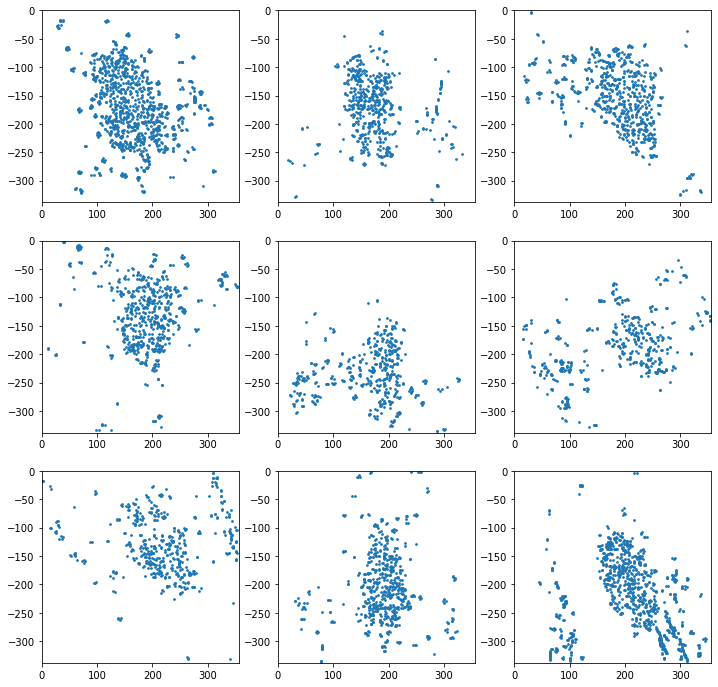

In [13]:
id_peaks2(lg_t_dv)

### Intensity Analysis

In [14]:
def intensities(group):
    group_int = []
    
    for img in group:
        
        intensities = []
        img_size = np.shape(img)[0]*np.shape(img)[1]
        
        norm_img = img/np.nanmedian(img)
        peaks = peak_local_max(norm_img, threshold_abs=4, indices=True) # Get the coordinates
        #print(np.shape(peaks))
        
        x = peaks[:,0]
        y = peaks[:,1]
    

        for i, j in zip(x,y):
            v = norm_img[i,j]
            intensities.append(v) # get the intensities
        m_intensities = np.nansum(intensities)/img_size
        
        group_int.append(m_intensities)
        
    
    return np.asarray(group_int)

#### ROI1: Ventral Telencephalon

##### Data Visualization

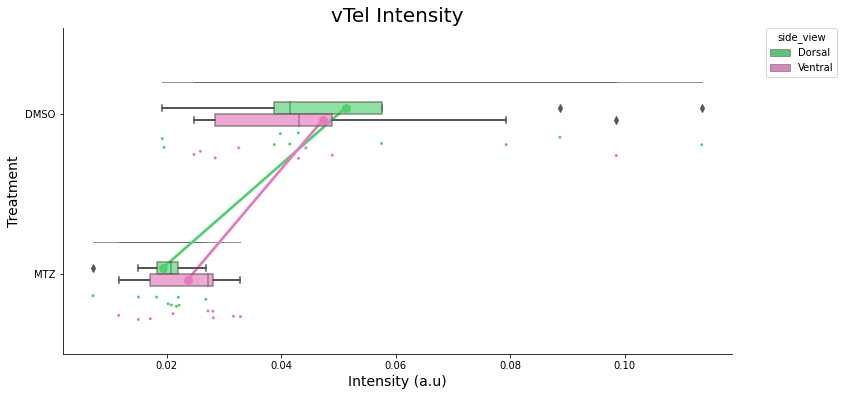

In [15]:
t_data = np.concatenate((intensities(lg_t_dd),intensities(lg_t_dv),intensities(lg_t_md),intensities(lg_t_mv)))

int_t_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'intensity':t_data}

df_intensity_t = pd.DataFrame(data=int_t_dict)
 

# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'intensity', data =df_intensity_t, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Intensity (a.u)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("vTel Intensity", fontsize =20)
sns.despine()
sns.set_style("white")

#### Statistics 

In [16]:
int_t_dd = intensities(lg_t_dd)
int_t_dv = intensities(lg_t_dv)
int_t_md = intensities(lg_t_md)
int_t_mv = intensities(lg_t_mv)

groups=[int_t_dd,int_t_dv,int_t_md,int_t_mv]

###### Normality Test

In [17]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.8611895442008972, 0.09878190606832504)
(0.8327820301055908, 0.047977980226278305)
(0.8803549408912659, 0.15837599337100983)
(0.9171270132064819, 0.36898526549339294)


###### Kruskal-Wallis Test 

In [18]:
stats.kruskal(int_t_dd,int_t_dv,int_t_md,int_t_mv)

KruskalResult(statistic=15.916916916916918, pvalue=0.0011793377164449458)

###### Conover Test

In [19]:
group=[int_t_dd,int_t_dv,int_t_md,int_t_mv]

sp.posthoc_conover(group, p_adjust = 'holm')

,1,2,3,4
1,-1.000000,0.773912,0.001911,0.021757
2,0.773912,-1.000000,0.001011,0.013831
3,0.001911,0.001011,-1.000000,0.558330
4,0.021757,0.013831,0.558330,-1.000000


Summary: 

Both treatment samples (dmso and mtz) are not significantly different regarding their side (dorsal vs. ventral):

- dd vs. dv: 0.774 > 0.05
- md vs. mv: 0.558 > 0.05
    
However, there is significant differrence between treated and non treated samples on both views:

- dd vs. md: 0.012 < 0.05
- dv vs. mv: 0.014 < 0.05

#### ROI2: Diencaphalon (POA+PT+RH)

##### Data Visualization

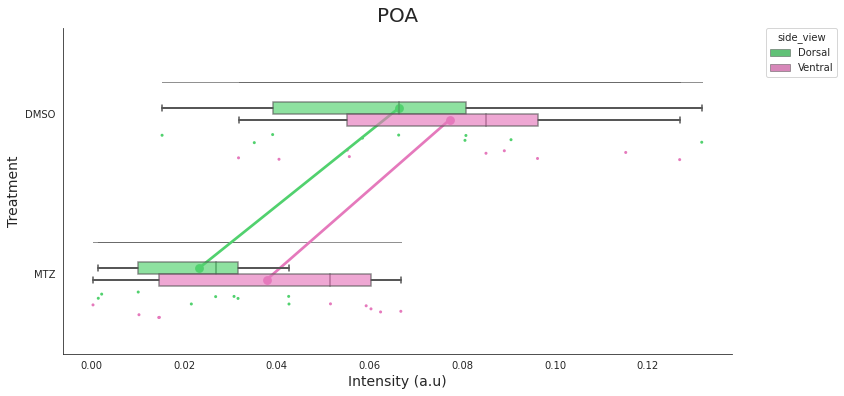

In [20]:
d_data = np.concatenate((intensities(lg_d_dd),intensities(lg_d_dv),intensities(lg_d_md),intensities(lg_d_mv)))

int_d_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'intensity':d_data}

df_intensity_d = pd.DataFrame(data=int_d_dict)

# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'intensity', data =df_intensity_d, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Intensity (a.u)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("POA", fontsize =20)
sns.despine()
sns.set_style("white")

#### Statistics 

In [21]:
int_d_dd = intensities(lg_d_dd)
int_d_dv = intensities(lg_d_dv)
int_d_md = intensities(lg_d_md)
int_d_mv = intensities(lg_d_mv)

groups=[int_d_dd,int_d_dv,int_d_md,int_d_mv]

###### Normality Test

In [22]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.9719440340995789, 0.9108251929283142)
(0.9478075504302979, 0.6660134196281433)
(0.9100365042686462, 0.31613093614578247)
(0.8227810859680176, 0.03704075142741203)


###### Kruskal-Wallis Test 

In [23]:
stats.kruskal(int_d_dd,int_d_dv,int_d_md,int_d_mv)

KruskalResult(statistic=13.678678678678665, pvalue=0.003376813806295458)

###### Conover Test

In [24]:
group=[int_d_dd,int_d_dv,int_d_md,int_d_mv]

sp.posthoc_conover(group, p_adjust = 'holm')

,1,2,3,4
1,-1.000000,0.532926,0.009150,0.161889
2,0.532926,-1.000000,0.001937,0.051930
3,0.009150,0.001937,-1.000000,0.343586
4,0.161889,0.051930,0.343586,-1.000000


Summary: 

Both treatment samples (dmso and mtz) are not significantly different regarding their side (dorsal vs. ventral) and neither are the samples between treatments in the ventral view:

- dd vs. dv: 0.533 > 0.05
- md vs. mv: 0.343 > 0.05
- dv vs. mv: 0.052 > 0.05
    
However, there is significant differrence between treated and non treated samples on the dorsal view:

- dd vs. md: 0.00915 < 0.05

#### ROI3: Arbitraty Center

##### Data Visualization

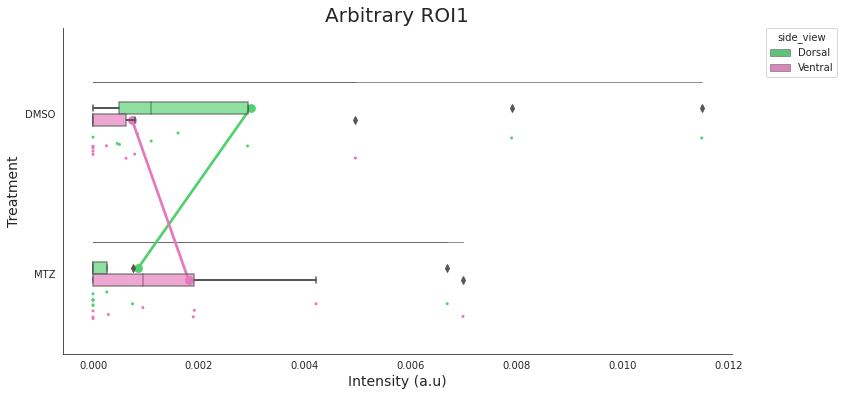

In [25]:
c_data = np.concatenate((intensities(lg_c_dd),intensities(lg_c_dv),intensities(lg_c_md),intensities(lg_c_mv)))

int_c_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'intensity':c_data}

df_intensity_c = pd.DataFrame(data=int_c_dict)

# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'intensity', data =df_intensity_c, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Intensity (a.u)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("Arbitrary ROI1", fontsize =20)
sns.despine()
sns.set_style("white")

#### Statistics 

In [26]:
int_c_dd = intensities(lg_c_dd)
int_c_dv = intensities(lg_c_dv)
int_c_md = intensities(lg_c_md)
int_c_mv = intensities(lg_c_mv)

groups=[int_c_dd,int_c_dv,int_c_md,int_c_mv]

###### Normality Test

In [27]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.7391851544380188, 0.0040606786496937275)
(0.5309392213821411, 1.4777863725612406e-05)
(0.46155500411987305, 2.255367917314288e-06)
(0.7943146824836731, 0.017582502216100693)


###### ANOVA Test 

In [28]:
from scipy.stats import f_oneway

f_oneway(int_c_dd,int_c_dv,int_c_md,int_c_mv)

F_onewayResult(statistic=1.3369421149125644, pvalue=0.27968238435481096)

Summary: 

There are no significant differences between the groups.
 

#### ROI4: Arbitraty Lateral

##### Data Visualization

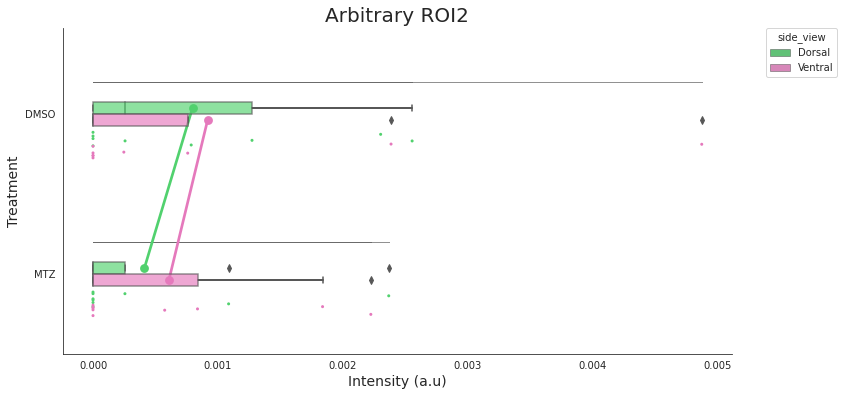

In [29]:
p_data = np.concatenate((intensities(lg_p_dd),intensities(lg_p_dv),intensities(lg_p_md),intensities(lg_p_mv)))

int_p_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'intensity':p_data}

df_intensity_p = pd.DataFrame(data=int_p_dict)

# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'intensity', data =df_intensity_p, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Intensity (a.u)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("Arbitrary ROI2", fontsize =20)
sns.despine()
sns.set_style("white")

#### Statistics 

In [30]:
int_p_dd = intensities(lg_p_dd)
int_p_dv = intensities(lg_p_dv)
int_p_md = intensities(lg_p_md)
int_p_mv = intensities(lg_p_mv)

groups=[int_p_dd,int_p_dv,int_p_md,int_p_mv]

###### Normality Test

In [31]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.7894257307052612, 0.015454825945198536)
(0.6475633382797241, 0.00034561651409603655)
(0.6064635515213013, 0.0001139360829256475)
(0.7497759461402893, 0.005389359313994646)


###### ANOVA Test 

In [32]:
from scipy.stats import f_oneway

f_oneway(int_p_dd,int_p_dv,int_p_md,int_p_mv)

F_onewayResult(statistic=0.3348211556913706, pvalue=0.8002268336062437)

Summary: 

There are no significant differences between the groups

### Density Analysis 

In [33]:
def densities(group):
    
    group_d = []
    
    for img in group:
        
        fig_size = np.shape(img)[0]*np.shape(img)[1]
        
        norm_img = img/np.nanmedian(img)
        peaks = peak_local_max(norm_img, threshold_abs=4, indices=True) # Get the coordinates
        
        n_peaks = np.shape(peaks)[0]
        
        pk_per_px = n_peaks/fig_size # Calculate the density
        group_d.append(pk_per_px)

    return np.asarray(group_d)

#### ROI1: Ventral Telencaphalon

##### Data Visualization

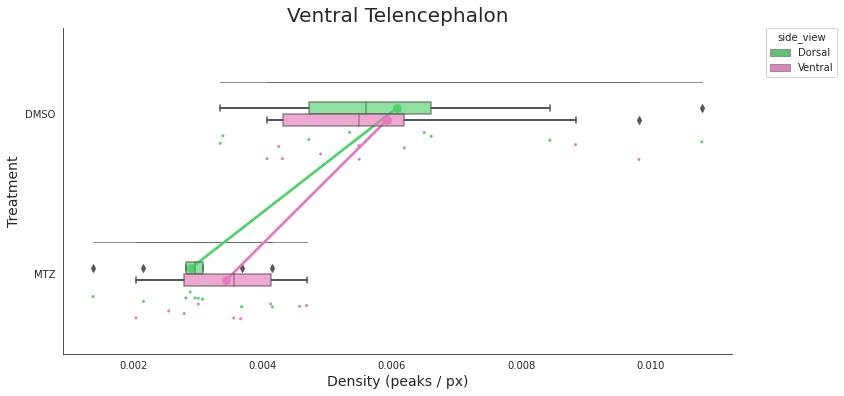

In [34]:
t_data = np.concatenate((densities(lg_t_dd),densities(lg_t_dv),densities(lg_t_md),densities(lg_t_mv)))

d_t_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'density':t_data}

df_density_t = pd.DataFrame(data=d_t_dict)


# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'density', data =df_density_t, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Density (peaks / px)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("Ventral Telencephalon", fontsize =20)
sns.despine()
sns.set_style("white")

##### Statistics

In [35]:
d_t_dd = densities(lg_t_dd)
d_t_dv = densities(lg_t_dv)
d_t_md = densities(lg_t_md)
d_t_mv = densities(lg_t_mv)

groups=[d_t_dd,d_t_dv,d_t_md,d_t_mv]

###### Normality Test

In [36]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.9286322593688965, 0.468433141708374)
(0.8266986012458801, 0.04100066423416138)
(0.9408950209617615, 0.5913516879081726)
(0.9583341479301453, 0.7807323336601257)


###### Kruskal Wallis Test

In [37]:
stats.kruskal(d_t_dd,d_t_dv,d_t_md,d_t_mv)

KruskalResult(statistic=20.135224038557805, pvalue=0.00015913380065461457)

###### Conover Test

In [38]:
group=[d_t_dd,d_t_dv,d_t_md,d_t_mv]

sp.posthoc_conover(group, p_adjust = 'holm')

,1,2,3,4
1,-1.000000,0.974017,0.000080,0.001097
2,0.974017,-1.000000,0.000080,0.001097
3,0.000080,0.000080,-1.000000,0.602759
4,0.001097,0.001097,0.602759,-1.000000


Summary: 

Both treatment samples (dmso and mtz) are not significantly different regarding their side (dorsal vs. ventral):

- dd vs. dv: 0.974 > 0.05
- md vs. mv: 0.603 > 0.05
    
However, there is significant differrence between treated and non treated samples on both views:

- dd vs. md: 0.000080 < 0.05
- dv vs. mv: 0.001097 < 0.05

#### ROI2: Diencephalon

##### Data Visualization

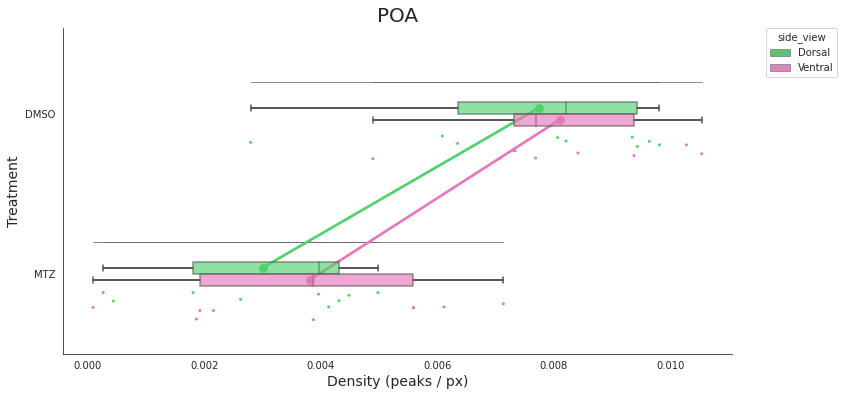

In [39]:
d_data = np.concatenate((densities(lg_d_dd),densities(lg_d_dv),densities(lg_d_md),densities(lg_d_mv)))

d_d_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'density':d_data}

df_density_d = pd.DataFrame(data=d_d_dict)


# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'density', data =df_density_d, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Density (peaks / px)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("POA", fontsize =20)
sns.despine()
sns.set_style("white")

##### Statistics

In [40]:
d_d_dd = densities(lg_d_dd)
d_d_dv = densities(lg_d_dv)
d_d_md = densities(lg_d_md)
d_d_mv = densities(lg_d_mv)

groups=[d_d_dd,d_d_dv,d_d_md,d_d_mv]

###### Normality Test

In [41]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.845640242099762, 0.06670504808425903)
(0.9453716278076172, 0.6394351720809937)
(0.8709964752197266, 0.12601208686828613)
(0.9280966520309448, 0.4634367823600769)


###### Kruskal Wallis Test

In [42]:
stats.kruskal(d_d_dd,d_d_dv,d_d_md,d_d_mv)

KruskalResult(statistic=20.81048612004978, pvalue=0.00011526029274599813)

###### Conover Test

In [43]:
group=[d_d_dd,d_d_dv,d_d_md,d_d_mv]

sp.posthoc_conover(group, p_adjust = 'holm')

,1,2,3,4
1,-1.000000,0.851968,0.000089,0.000543
2,0.851968,-1.000000,0.000040,0.000277
3,0.000089,0.000040,-1.000000,0.851968
4,0.000543,0.000277,0.851968,-1.000000


Summary: 

Both treatment samples (dmso and mtz) are not significantly different regarding their side (dorsal vs. ventral):

- dd vs. dv: 0.852 > 0.05
- md vs. mv: 0.852 > 0.05
    
However, there is significant differrence between treated and non treated samples on both views:

- dd vs. md: 0.000089 < 0.05
- dv vs. mv: 0.000277 < 0.05

#### ROI3: Arbitraty Center

##### Data Visualization

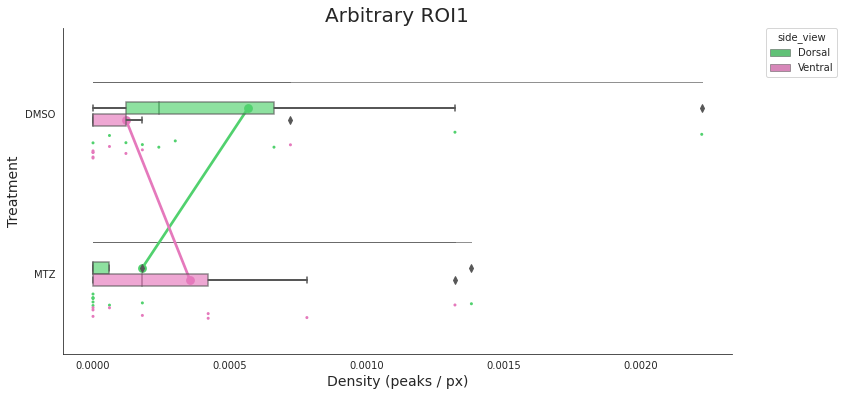

In [44]:
c_data = np.concatenate((densities(lg_c_dd),densities(lg_c_dv),densities(lg_c_md),densities(lg_c_mv)))

d_c_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'density':c_data}

df_density_c = pd.DataFrame(data=d_c_dict)


# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'density', data =df_density_c, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Density (peaks / px)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("Arbitrary ROI1", fontsize =20)
sns.despine()
sns.set_style("white")

##### Statistics

In [45]:
d_c_dd = densities(lg_c_dd)
d_c_dv = densities(lg_c_dv)
d_c_md = densities(lg_c_md)
d_c_mv = densities(lg_c_mv)

groups=[d_c_dd,d_c_dv,d_c_md,d_c_mv]

###### Normality Test

In [46]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.7618297338485718, 0.007432532496750355)
(0.5961571335792542, 8.62400556798093e-05)
(0.4724732041358948, 3.0324154067784548e-06)
(0.8147498369216919, 0.030053187161684036)


###### ANOVA Test

In [47]:
from scipy.stats import f_oneway

f_oneway(d_c_dd,d_c_dv,d_c_md,d_c_mv)

F_onewayResult(statistic=1.426750755485481, pvalue=0.2531099287787995)

#### ROI4: Arbitraty Lateral

##### Data Visualization

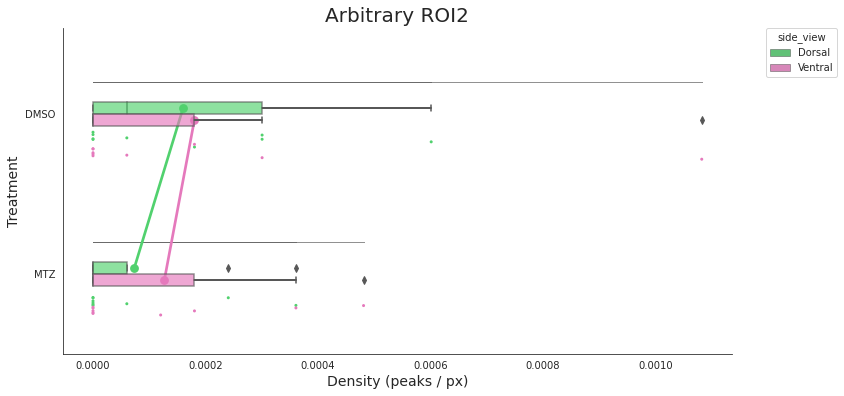

In [48]:
p_data = np.concatenate((densities(lg_p_dd),densities(lg_p_dv),densities(lg_p_md),densities(lg_p_mv)))

d_p_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'density':p_data}

df_density_p = pd.DataFrame(data=d_p_dict)


# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'density', data =df_density_p, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Density (peaks / px)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("Arbitrary ROI2", fontsize =20)
sns.despine()
sns.set_style("white")

##### Statistics

In [49]:
d_p_dd = densities(lg_p_dd)
d_p_dv = densities(lg_p_dv)
d_p_md = densities(lg_p_md)
d_p_mv = densities(lg_p_mv)

groups=[d_p_dd,d_p_dv,d_p_md,d_p_mv]

###### Normality Test

In [50]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.8037716746330261, 0.022548047825694084)
(0.5992443561553955, 9.3743612524122e-05)
(0.6389408111572266, 0.00027387114823795855)
(0.7593700885772705, 0.006961159873753786)


###### ANOVA Test

In [51]:
from scipy.stats import f_oneway

f_oneway(d_p_dd,d_p_dv,d_p_md,d_p_mv)

F_onewayResult(statistic=0.35754530226892034, pvalue=0.7840115614925015)

### Dispersion Analysis

In [52]:
def dispersion(group):
    
    group_distance = []
    
    for img in group:
        
        norm_img = img/np.nanmedian(img)
        peaks = peak_local_max(norm_img, threshold_abs=4, indices=True) # Get the coordinates
        
        n_peaks = np.shape(peaks)[0]

        
        neigh = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(peaks)
        distance_matrix = neigh.kneighbors_graph(peaks, mode = 'distance').toarray()
        
        distance_neighbour = np.nanmean(distance_matrix)
        group_distance.append(distance_neighbour)
    
    return np.asarray(group_distance)

#### ROI1: Ventral Telencaphalon

##### Data Visualization

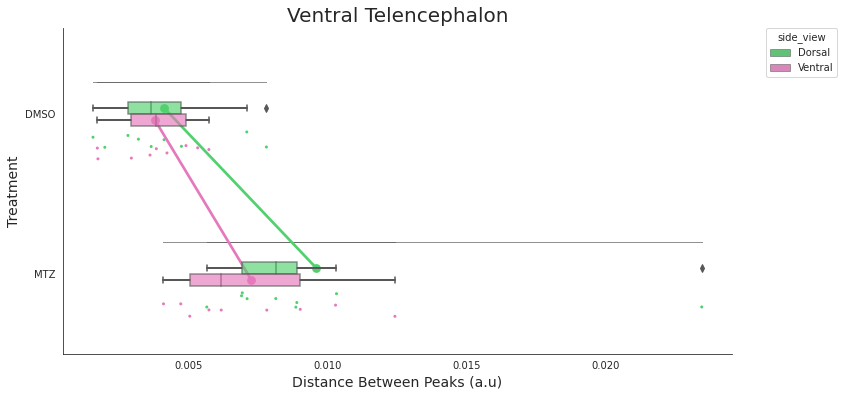

In [53]:
t_data = np.concatenate((dispersion(lg_t_dd),dispersion(lg_t_dv),dispersion(lg_t_md),dispersion(lg_t_mv)))

dist_t_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'distance':t_data}

df_distance_t = pd.DataFrame(data=dist_t_dict)


# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'distance', data =df_distance_t, hue = 'side_view', palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)



plt.xlabel('Distance Between Peaks (a.u)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("Ventral Telencephalon", fontsize =20)
sns.despine()
sns.set_style("white")

##### Statistics

In [54]:
dist_t_dd = dispersion(lg_t_dd)
dist_t_dv = dispersion(lg_t_dv)
dist_t_md = dispersion(lg_t_md)
dist_t_mv = dispersion(lg_t_mv)

groups=[dist_t_dd,dist_t_dv,dist_t_md,dist_t_mv]

###### Normality Test

In [55]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.9174429774284363, 0.37149110436439514)
(0.9386785626411438, 0.5680601596832275)
(0.6358033418655396, 0.00025163503596559167)
(0.9230319857597351, 0.4179326891899109)


###### Kruskal Wallis Test

In [56]:
stats.kruskal(dist_t_dd,dist_t_dv,dist_t_md,dist_t_mv)

KruskalResult(statistic=18.243243243243256, pvalue=0.00039185127867110613)

###### Conover Test

In [57]:
group=[dist_t_dd,dist_t_dv,dist_t_md,dist_t_mv]

sp.posthoc_conover(group, p_adjust = 'holm')

,1,2,3,4
1,-1.000000,0.782616,0.000371,0.006437
2,0.782616,-1.000000,0.000199,0.004051
3,0.000371,0.000199,-1.000000,0.473530
4,0.006437,0.004051,0.473530,-1.000000


Summary: 

Both treatment samples (dmso and mtz) are not significantly different regarding their side (dorsal vs. ventral):

- dd vs. dv: 0.783 > 0.05
- md vs. mv: 0.473 > 0.05
    
However, there is significant differrence between treated and non treated samples on both views:

- dd vs. md: 0.000371 < 0.05
- dv vs. mv: 0.004051 < 0.05

#### ROI2: Diencephalon

##### Data Visualization

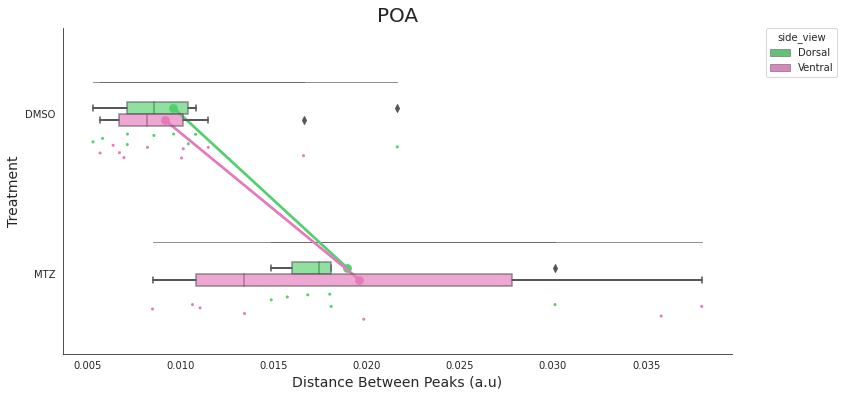

In [58]:
d_data = np.concatenate((dispersion(lg_d_dd),dispersion(lg_d_dv),dispersion(lg_d_md),dispersion(lg_d_mv)))

dist_d_dict = {'condition':['DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','DMSO','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ','MTZ'],
    'side_view':['Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Dorsal','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral','Ventral'],
    'distance':d_data}

df_distance_d = pd.DataFrame(data=dist_d_dict)

Q1 = df_distance_d['distance'].quantile(0.25)
Q3 = df_distance_d['distance'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtered = (df_distance_d['distance'] >= Q1 - 1.5 * IQR) & (df_distance_d['distance'] <= Q3 + 1.5 *IQR)
new_df_distance_d = df_distance_d[filtered]  


# Boxplot 

ort="h"; pal = ['#51D16E','#E579BC']; sigma = .2

f, ax = plt.subplots(figsize=(12, 6))

ax = pt.RainCloud(x = 'condition', y = 'distance', data =new_df_distance_d, hue = 'side_view',palette = pal, bw = sigma, width_viol = 0,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)


plt.xlabel('Distance Between Peaks (a.u)', fontsize=14)
plt.ylabel('Treatment', fontsize=14)
plt.title("POA", fontsize =20)
sns.despine()
sns.set_style("white")

##### Statistics

In [59]:
dist_d_dd = dispersion(lg_d_dd)
dist_d_dv = dispersion(lg_d_dv)
dist_d_md = dispersion(lg_d_md)
dist_d_mv = dispersion(lg_d_mv)

groups=[dist_d_dd,dist_d_dv,dist_d_md,dist_d_mv]

###### Normality Test

In [60]:
## Shapiro Wilk in which the data is the average intensity of each image

for group in groups:    
    print(stats.shapiro(group))

(0.761497974395752, 0.007367169484496117)
(0.8724790215492249, 0.13069318234920502)
(0.5125278234481812, 8.976838216767646e-06)
(0.39323437213897705, 3.5284756449982524e-07)


###### Kruskal Wallis Test

In [61]:
stats.kruskal(dist_d_dd,dist_d_dv,dist_d_md,dist_d_mv)

KruskalResult(statistic=18.959959959959946, pvalue=0.00027866037600033223)

###### Conover Test

In [62]:
group=[dist_d_dd,dist_d_dv,dist_d_md,dist_d_mv]

sp.posthoc_conover(group, p_adjust = 'holm')

,1,2,3,4
1,-1.000000,0.826347,0.000278,0.002237
2,0.826347,-1.000000,0.000176,0.001612
3,0.000278,0.000176,-1.000000,0.732652
4,0.002237,0.001612,0.732652,-1.000000


Summary: 

Both treatment samples (dmso and mtz) are not significantly different regarding their side (dorsal vs. ventral):

- dd vs. dv: 0.826 > 0.05
- md vs. mv: 0.733 > 0.05
    
However, there is significant differrence between treated and non treated samples on both views:

- dd vs. md: 0.000278 < 0.05
- dv vs. mv: 0.001612 < 0.05